<a href="https://colab.research.google.com/github/Valerie-Osawe/Stutern/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# Built-in library
import itertools
import re
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 1_000

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


> Data source is from **Kaggle**.

- The data can be found [here](https://www.kaggle.com/datasets/nenamalikah/nlp-ulta-skincare-reviews).

### Data Dictionary

```
- Review Title: The title of the review.
- Review_Text: The full text of the review.
- Verified_Buyer: Whether the reviewer is a verified buyer of the product.
- Review_Date: The date the review was published relative to the review scrape date.
- Review_Location: The location of the reviewer.
- Review_Upvotes: How many times the review was upvoted by other reviewers.
- Review_Downvotes: How many times the review was downvoted by other reviewers.
- Product: The name of the product the review was issued for.
- Brand: The brand of the product.
- Scrape Date: The date the data was pulled from the web.
```

### Objectives

```
1. Exploratory Data Analysis.

2. Sentiments Analysis.

3. Building Models.

```


<br><hr>

# 1. Exploratory Data Analysis

### Explore the data. What can the reviews tell us about the products? Do most buyers have common skincare issues? What issues did the products help solve or exacerbate?


In [46]:
skin_review = pd.read_csv('Ulta Skincare Reviews.csv')
skin_review.head()

,Review_Title,Review_Text,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date
0,Perfect,Love using this on my face while in the shower. Heats up and gives a light scrub nicely,No,15 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23
1,You need this,Even better than the daily microfoliant. I'm obsessed. My skin is SO MUCH smoother,No,27 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23
2,Clean skin,Enjoy this product so much ! I look forward to using it - really feels great.,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23
3,Love This Stuff!,I've never tried anything like this before and I love it. When you apply it to your face you get a little shot of warm that feels so good. The scrub seems very gritty but the only side effects I've encountered have been positive ones.,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23
4,This exfoliates very nicely and,"This exfoliates very nicely and gives a very smooth skin after with no irritation and no reaction to the skin . I highly recommended it, i will buy it again.",No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23


In [47]:
skin_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4150 entries, 0 to 4149
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Review_Title      4150 non-null   object
 1   Review_Text       4148 non-null   object
 2   Verified_Buyer    4150 non-null   object
 3   Review_Date       4150 non-null   object
 4   Review_Location   4149 non-null   object
 5   Review_Upvotes    4150 non-null   int64 
 6   Review_Downvotes  4150 non-null   int64 
 7   Product           4150 non-null   object
 8   Brand             4150 non-null   object
 9   Scrape_Date       4150 non-null   object
dtypes: int64(2), object(8)
memory usage: 324.3+ KB


In [48]:
# check the row with missing values
missing_rows = skin_review.isnull().any(axis = 1)
skin_review[missing_rows]

,Review_Title,Review_Text,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date
3397,Half full product,"The only reason I'm rating this three stars is because it's already a travel-size item, do they really needs to only fill the bottle up halfway? For how pricey this travel size bottle is, they could at least fill the whole thing up or use a smaller container, because otherwise it seems misleading.",No,2 years ago,NaN,2,0,Daily Microfoliant,Dermalogica,3/27/23
3684,Received a sample and loved it!,NaN,Yes,4 years ago,"Columbia, SC",0,0,Daily Microfoliant,Dermalogica,3/27/23
3686,This product works,NaN,Yes,4 years ago,"Columbia, SC",0,0,Daily Microfoliant,Dermalogica,3/27/23


In [49]:
# Replace missing value in Review_Location with undisclosed
skin_review['Review_Location'] = skin_review['Review_Location'].fillna('Undisclosed')

# Replace the missing values in Review_Text with values in Review_Title
skin_review['Review_Text'] = skin_review['Review_Text'].fillna(skin_review['Review_Title'])

In [50]:
# check for duplicate rows
skin_review.duplicated().sum()

456

In [51]:
# Drop duplicates
skin_review = skin_review.drop_duplicates(keep = 'first')

##Are the buyers with reviews verified buyers?

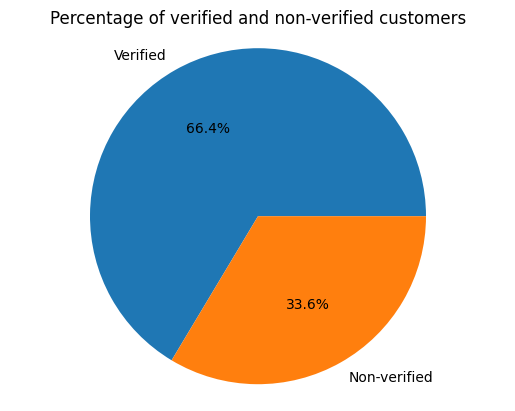

In [52]:
labels = ['Verified', 'Non-verified']
values = skin_review.Verified_Buyer.value_counts()

# Plotting the pie chart
plt.pie(values, labels=labels, autopct='%1.1f%%')
# Title
plt.title('Percentage of verified and non-verified customers')
# Aspect ratio
plt.axis('equal')
# Display the chart
plt.show()

From the chart above, it can be seen that 66% of the buyers are verified buyers.

## Where are the buyers locations?

In [53]:
# Calculate value counts
loc = skin_review.Review_Location.value_counts()
loc

Undisclosed       909
London             71
Florida            45
California         43
Texas              41
                 ... 
tulsa oklahoma      1
Nipomo ca           1
Michigan, USA       1
St Albans           1
Fayetteville        1
Name: Review_Location, Length: 1423, dtype: int64

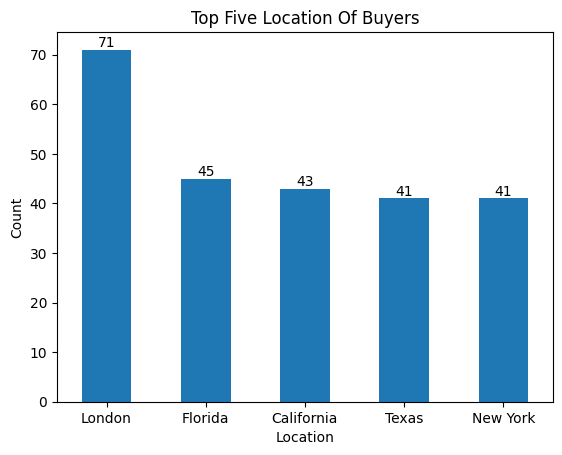

In [54]:
# Select the top five excluding the first row
top_five = loc.sort_values(ascending=False).head(6).iloc[1:]

# Plot the chart
ax = top_five.plot.bar()

# Add annotations to the bars
for i, v in enumerate(top_five):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Set labels and title
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Top Five Location Of Buyers')
# Rotate x-axis tick labels
plt.xticks(rotation=0)

# Show the chart
plt.show()

The first row of the location with the most buyers was excluded because the row value was 'undisclosed' which gives no information to where the buyers are from.

From the chart it can be seen that the location of with most buyers is London

## What products were bought the most

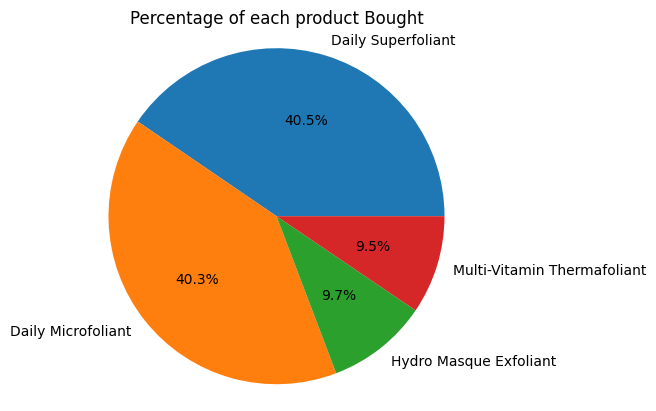

In [55]:
product = skin_review['Product'].value_counts()
# Create an array of zeros of the same length as 'product_counts' to indicate no explosion
explode = [0] * len(product)
# Plotting the pie chart
plt.pie(product, labels = product.index, explode=explode, autopct='%1.1f%%')
# Title
plt.title('Percentage of each product Bought')
# Aspect ratio
plt.axis('equal')
# Display the chart
plt.show()

It can be seen from the plot above that Daily microfoliant and daily superfoliant were the products bought the most.

##In each of the top 5 location which products were bought the most?

In [56]:
# Get a list of all locations of interest
locations_of_interest = top_five.index.tolist()
# Create an empty DataFrame to store the results
most_used_products = pd.DataFrame(columns=['location', 'most_used_product'])

# Loop through each location of interest
for location in locations_of_interest:
    # Filter the data for the specific location
    filtered_data = skin_review[skin_review['Review_Location'] == location]

    # Get the mode of the 'product' column (most used product)
    most_used_product = filtered_data['Product'].mode().iloc[0]

    # Add the result to the DataFrame
    most_used_products = most_used_products.append({'location': location, 'most_used_product': most_used_product},
                                                   ignore_index=True)

# Print the result
most_used_products


<ipython-input-56-1843b11ecf49>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  most_used_products = most_used_products.append({'location': location, 'most_used_product': most_used_product},
<ipython-input-56-1843b11ecf49>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  most_used_products = most_used_products.append({'location': location, 'most_used_product': most_used_product},
<ipython-input-56-1843b11ecf49>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  most_used_products = most_used_products.append({'location': location, 'most_used_product': most_used_product},
<ipython-input-56-1843b11ecf49>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.c

,location,most_used_product
0,London,Daily Superfoliant
1,Florida,Daily Microfoliant
2,California,Daily Microfoliant
3,Texas,Daily Microfoliant
4,New York,Daily Microfoliant


It can be seen that amongst the top five countries all buyers except the buyers from London bought daily microfoliant the most while London buyers mostly bought daily superfoliant.

## What can the reviews tell us about the products?

In [57]:
skin_review['Review_Text'] = skin_review['Review_Text'].str.lower()
skin_review['Review_Text'].head()

0                                                                                                                                                       love using this on my face while in the shower. heats up and gives a light scrub nicely
1                                                                                                                                                            even better than the daily microfoliant. i'm obsessed. my skin is so much smoother
2                                                                                                                                                                 enjoy this product so much ! i look forward to using it - really feels great.
3    i've never tried anything like this before and i love it. when you apply it to your face you get a little shot of warm that feels so good. the scrub seems very gritty but the only side effects i've encountered have been positive ones.
4                                       

In [58]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
skin_review['clean_review'] = skin_review['Review_Text'].apply(lambda x: ' '.join([word for word in word_tokenize(x.lower()) if word.isalpha() and word not in stop_words]))

# create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# define a function to lemmatize a string
def lemmatize_string(string):
    # split the string into words
    words = string.split()
    # lemmatize each word
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    # join the lemmatized words back into a string
    lemmatized_string = ' '.join(lemmatized_words)
    return lemmatized_string

# apply the lemmatize_string function to the 'text' column of the DataFrame
skin_review['lemmatized_text'] = skin_review['clean_review'].apply(lemmatize_string)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The review column was lemmatized using WordNetLemmatizer. In natural language processing, lemmatization is used to prepare text for analysis by reducing words to their base form to make it easier to analyze and extract meaning from the text. For example, the lemma of "am," "is," and "are" is "be."

### Create a wordcloud showing the words/phrases commonly associated with each product.

To do this the names of each product has to be checked.  query() is used to get rows of each products.  Common words are filtered out from review text column using stopwords. The stopwords are updated to have common names associated to the products

In [59]:
# check names of product
skin_review.Product.unique()

array(['Multi-Vitamin Thermafoliant', 'Hydro Masque Exfoliant',
       'Daily Superfoliant', 'Daily Microfoliant'], dtype=object)

Word Cloud For Multi-Vitamin Thermafoliant



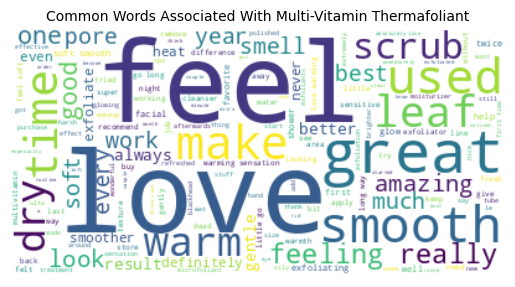

In [60]:
from wordcloud import WordCloud, STOPWORDS
# define the product
product1_df = skin_review.query("Product == 'Multi-Vitamin Thermafoliant'")
reviews = ' '.join([string for string in product1_df.lemmatized_text])

# Define and update the list of stopwords
my_stopwords = set(STOPWORDS)
list_stopwords = ['skin', 'product', 'daily', 'face', 'exfoliators', 'thermafoliant', 'dermalogica', 'exfoliant', 'mask', 'products', 'use', 'clean', 'cleaner', 'superfoliant', 'using', 'day', 'week', 'masque']
my_stopwords = STOPWORDS.update(list_stopwords)

# Create and generate a word cloud image
my_cloud = WordCloud(background_color='white', stopwords=my_stopwords).generate(reviews)

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Common Words Associated With Multi-Vitamin Thermafoliant', fontsize=10)
plt.show()

From the word cloud it shows that there are mostly positive reveiw for the product, Multi-Vitamin Thermafoliant. Some of the most common words used in the reviews of the products were love, great, feel, amazing, smooth etc.

Word Cloud For Hydro Masque Exfoliant

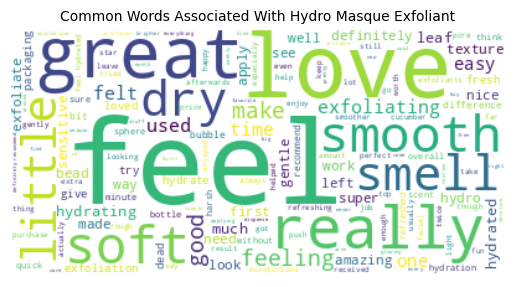

In [61]:
# define the product
product2_df = skin_review.query("Product == 'Hydro Masque Exfoliant'")
reviews = ' '.join([string for string in product2_df.lemmatized_text])

# Create and generate a word cloud image
my_cloud = WordCloud(background_color='white', stopwords=my_stopwords).generate(reviews)

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Common Words Associated With Hydro Masque Exfoliant', fontsize=10)
plt.show()

From the word cloud it shows that there are mostly positive reveiw for the product, Hydro Masque Exfoliant. Some of the most common words used in the reviews of the products were smooth, soft, love, gentle etc

Word Cloud For Daily Superfoliant

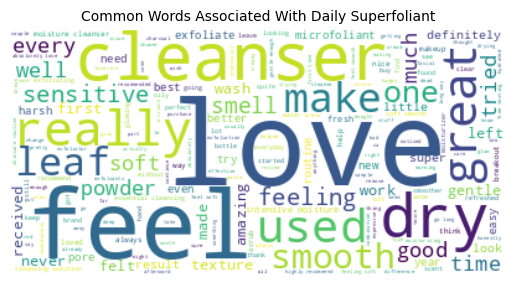

In [62]:
# define the product
product3_df = skin_review.query("Product == 'Daily Superfoliant'")
reviews = ' '.join([string for string in product3_df.lemmatized_text])

# Create and generate a word cloud image
my_cloud = WordCloud(background_color='white', stopwords=my_stopwords).generate(reviews)

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Common Words Associated With Daily Superfoliant', fontsize=10)
plt.show()

From the word cloud it shows that there are mostly positive reveiw for the product, Daily Superfoliant. Some of the most common words used in the reviews of the products were smooth, soft, love, gentle, feel, sensetive etc

Word Cloud For Daily Microfoliant

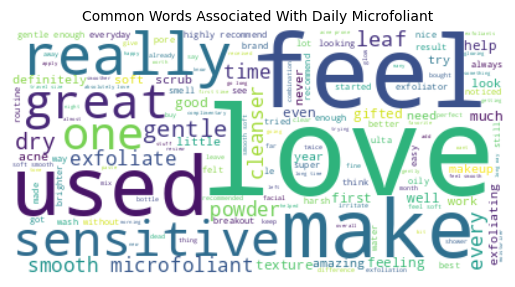

In [63]:
# define the product
product4_df = skin_review.query("Product == 'Daily Microfoliant'")
reviews = ' '.join([string for string in product4_df.lemmatized_text])

# Create and generate a word cloud image
my_cloud = WordCloud(background_color='white', stopwords=my_stopwords).generate(reviews)

# Display the generated wordcloud image
plt.imshow(my_cloud, interpolation='bilinear')
plt.axis("off")
plt.title('Common Words Associated With Daily Microfoliant', fontsize=10)
plt.show()

From the word cloud it shows that there are mostly positive reveiw for the product, Daily Microfoliant. Some of the most common words used in the reviews of the products were smooth, soft, love, gentle, feel, sensetive etc.

Overall the reviews on all the products mostly have positive remarks

#### Do most buyers have common skincare issues ?
> #### What issues did the products help solve or exacerbate?
From each of the word cloud of the products it can be seen that a common word between the four product is  exfoliant or exfoliating. Which means the four products most likely have the same functions. This means most buyers have common skincare issues.

Another recurring word in the word clouds of the products was smooth and soft. Therefore the products helped to improve skin texture

# Sentiment Analysis

### Perform sentiment analysis.
To do this SentimentIntensityAnalyzer is used. it assigns a sentiment score to each word in the text on a scale from -1 to +1, where negative values indicate negative sentiment, positive values indicate positive sentiment, and a score of 0 indicates neutral sentiment. It then computes an overall sentiment score for the text by aggregating the individual word scores. This is done to get our target columnn before training our data with a machine learning model.

The feature column which are the reviews are also converted to numerics using TfidfVectorizer while removing stop words from the reviews. TfidfVectorizer measures the relative importance of each word in a document or corpus. It does this by scaling the frequency of each word by the frequency of that word in the entire corpus. This helps to down-weight the importance of commonly occurring words like “the” and “and”, while highlighting words that are more unique to specific documents.

In [64]:
sia = SentimentIntensityAnalyzer()
sentiment_scores = skin_review['lemmatized_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

# create add a column to the dataframe that shows if the review is positive or not
skin_review['label'] = sentiment_scores.apply(lambda x: 1 if x > 0 else 0)


In [65]:
# Create a new feature for the lengh of each review
skin_review['review_length'] = skin_review['clean_review'].apply(lambda x: len(x.split()))
skin_review.head()

,Review_Title,Review_Text,Verified_Buyer,Review_Date,Review_Location,Review_Upvotes,Review_Downvotes,Product,Brand,Scrape_Date,clean_review,lemmatized_text,label,review_length
0,Perfect,love using this on my face while in the shower. heats up and gives a light scrub nicely,No,15 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,love using face shower heats gives light scrub nicely,love using face shower heat give light scrub nicely,1,9
1,You need this,even better than the daily microfoliant. i'm obsessed. my skin is so much smoother,No,27 days ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,even better daily microfoliant obsessed skin much smoother,even better daily microfoliant obsessed skin much smoother,1,8
2,Clean skin,enjoy this product so much ! i look forward to using it - really feels great.,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,enjoy product much look forward using really feels great,enjoy product much look forward using really feel great,1,9
3,Love This Stuff!,i've never tried anything like this before and i love it. when you apply it to your face you get a little shot of warm that feels so good. the scrub seems very gritty but the only side effects i've encountered have been positive ones.,No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,never tried anything like love apply face get little shot warm feels good scrub seems gritty side effects encountered positive ones,never tried anything like love apply face get little shot warm feel good scrub seems gritty side effect encountered positive one,1,21
4,This exfoliates very nicely and,"this exfoliates very nicely and gives a very smooth skin after with no irritation and no reaction to the skin . i highly recommended it, i will buy it again.",No,2 months ago,Undisclosed,0,0,Multi-Vitamin Thermafoliant,Dermalogica,3/27/23,exfoliates nicely gives smooth skin irritation reaction skin highly recommended buy,exfoliates nicely give smooth skin irritation reaction skin highly recommended buy,1,11


In [66]:
# Import the TfidfVectorizer and default list of English stop words
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
# Build the vectorizer
vect = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), max_features=100, token_pattern=r'\b[^\d\W][^\d\W]+\b').fit(skin_review.lemmatized_text)
# Create sparse matrix from the vectorizer
X = vect.transform(skin_review.lemmatized_text)

# Create a DataFrame
reviews_transformed = pd.DataFrame(X.toarray(), columns=[x for x in sorted(vect.vocabulary_, key=vect.vocabulary_.get)])
reviews_transformed.head()

,absolutely,acne,amazing,best,better,bit,brighter,buy,clean,cleanser,cleansing,daily,day,definitely,dermalogica,difference,dry,dry skin,easy,exfoliant,exfoliate,exfoliating,exfoliator,face,face feel,feel,feel like,feeling,felt,free,fresh,gentle,good,got,great,hand,harsh,help,highly,leaf,leaf skin,left,like,little,long,look,looking,love,love product,make,make skin,makeup,mask,microfoliant,morning,need,new,nice,night,oily,pore,powder,product,really,received,recommend,result,review,routine,scrub,sensitive,sensitive skin,size,skin,skin feel,skin feeling,skincare,smell,smooth,smoother,soft,super,superfoliant,texture,think,time,time week,tried,try,use,use daily,used,using,using product,wash,water,way,week,work,year
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.420348,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.378455,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.707146,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.424293,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.515212,0.0,0.0,0.000000,0.0,0.0,0.0,0.394986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.513367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.181881,0.0,0.0,0.0,0.0,0.000000,0.530958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.345863,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.430994,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.528674,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.26809,0.449221,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.376106,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274818,0.0,0.255092,0.0,0.0,0.0,0.0,0.0,0.0,0.394595,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.304199,0.379506,0.0,0.000000,0.0,0.247429,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.462323,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.438373,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.605743,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.596865,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.383174,0.0,0.0,0.0,0.0,0.360562,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Building  Machine Learning Models

 ## Build a ML model that can predict whether a review is positive or negative

In [67]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, precision_score, recall_score, f1_score
# Define X and y
X = reviews_transformed
y = skin_review.label

# Train/test split
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=456)


### Model 1

In [68]:
# Train a logistic regression
model_1 = LogisticRegression().fit(X_train, y_train)
# Predict the labels
y_predicted = model_1.predict(X_test)
# Get predicted probabilities for positive class
y_pred_proba = model_1.predict_proba(X_test)[:, 1]

# Print the results of the evaulation metrics
print('Accuracy on the test set: \n',  accuracy_score(y_test, y_predicted))
print("Precision: \n", precision_score(y_test, y_predicted))
print("Recall: \n", recall_score(y_test, y_predicted))
print("F1-Score: \n", f1_score(y_test, y_predicted))
print("AUC Score:", roc_auc_score(y_test, y_pred_proba))

Accuracy on the test set: 
 0.8836265223274695
Precision: 
 0.8837209302325582
Recall: 
 0.9984544049459042
F1-Score: 
 0.9375907111756168
AUC Score: 0.8920015455950541


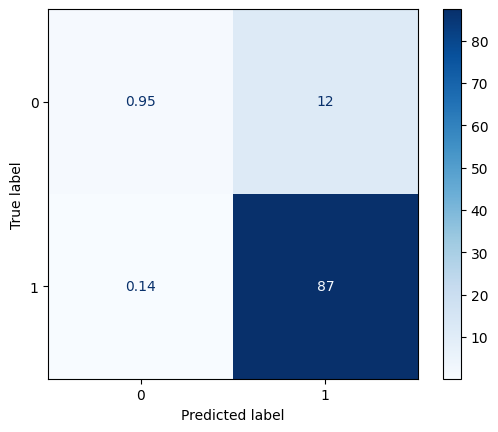

In [69]:
# plot confusion matix
cm = confusion_matrix(y_test, y_predicted)
# Calculate percentages
cm_percent = np.round((cm / cm.sum()) * 100, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percent)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Looking at the matrix, we can see that the model has correctly predicted the negative class (actual negative) in 0.95% of the cases, and the positive class (actual positive) in 87% of the cases.

On the other hand, the model has misclassified 12% of the negative reviews as positive (false positives), and 0.14% of the positive reviews as negative (false negatives).

Overall, the model seems to perform quite well, with a high accuracy and a low false negative rate. However, the false positive rate is relatively high, which means that the model is more likely to mistakenly classify a negative review as positive than the other way around.

### Model 2

In [70]:
# Train a Random forest classifier
model_2 = RandomForestClassifier().fit(X_train, y_train)
# Predict the labels
predicted_2 = model_2.predict(X_test)
# Get predicted probabilities for positive class
pred_proba_2 = model_2.predict_proba(X_test)[:, 1]

# Print the results of the evaulation metrics
print('Accuracy on the test set: \n',  accuracy_score(y_test, predicted_2))
print("Precision: \n", precision_score(y_test, predicted_2))
print("Recall: \n", recall_score(y_test, predicted_2))
print("F1-Score: \n", f1_score(y_test, predicted_2))
print("AUC Score:", roc_auc_score(y_test, pred_proba_2))

Accuracy on the test set: 
 0.8876860622462788
Precision: 
 0.8960674157303371
Recall: 
 0.9860896445131375
F1-Score: 
 0.938925680647535
AUC Score: 0.854210066527787


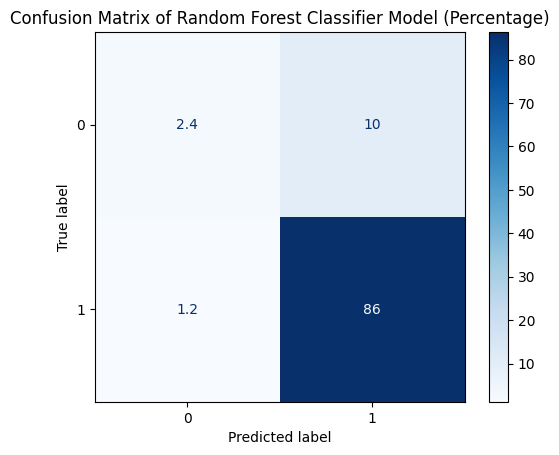

In [71]:
# plot confusion matix
cm_2 = confusion_matrix(y_test, predicted_2)
# Calculate percentages
cm_percent_2 = np.round((cm_2 / cm_2.sum()) * 100, 2)
disp_2 = ConfusionMatrixDisplay(confusion_matrix=cm_percent_2)
disp_2.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Random Forest Classifier Model (Percentage)')
plt.show()

Looking at the matrix, we can see that the model has correctly predicted the negative class (actual negative) in 2.3% of the cases, and the positive class (actual positive) in 86% of the cases.

On the other hand, the model has misclassified 10% of the negative reviews as positive (false positives), and 1.4% of the positive reviews as negative (false negatives).


### Model 3

In [72]:
# Train a Gradient boosting classifer
model_3 = GradientBoostingClassifier().fit(X_train, y_train)
# Predict the labels
predicted_3 = model_3.predict(X_test)

# Get predicted probabilities for positive class
pred_proba_3 = model_3.predict_proba(X_test)[:, 1]

# Print the results of the evaulation metrics
print('Accuracy on the test set: \n',  accuracy_score(y_test, predicted_3))
print("Precision: \n", precision_score(y_test, predicted_3))
print("Recall: \n", recall_score(y_test, predicted_3))
print("F1-Score: \n", f1_score(y_test, predicted_3))
print("AUC Score:", roc_auc_score(y_test, pred_proba_3))

Accuracy on the test set: 
 0.8836265223274695
Precision: 
 0.8879668049792531
Recall: 
 0.9922720247295209
F1-Score: 
 0.9372262773722627
AUC Score: 0.861518043142262


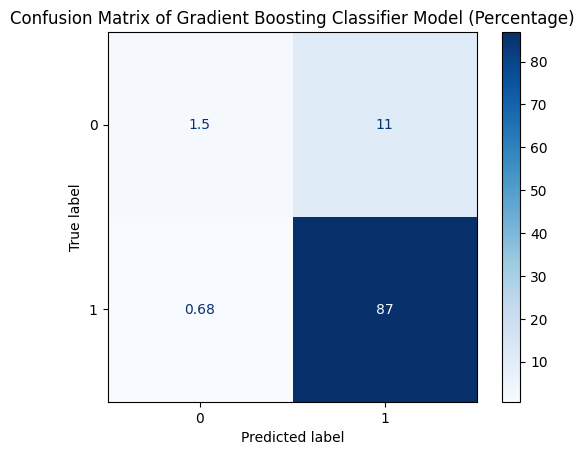

In [73]:
# plot confusion matix
cm_3 = confusion_matrix(y_test, predicted_3)
# Calculate percentages
cm_percent_3 = np.round((cm_3 / cm_3.sum()) * 100, 2)
disp_3 = ConfusionMatrixDisplay(confusion_matrix=cm_percent_3)
disp_3.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Gradient Boosting Classifier Model (Percentage)')
plt.show()

Looking at the matrix, we can see that the model has correctly predicted the negative class (actual negative) in 1.1% of the cases, and the positive class (actual positive) in 87% of the cases.

On the other hand, the model has misclassified 11% of the negative reviews as positive (false positives), and 0.68% of the positive reviews as negative (false negatives).

In [74]:
# list of models and their respective evaluation metrics
models = ['Model 1', 'Model 2', 'Model 3']
accuracy = [0.85, 0.90, 0.88]
precision = [0.82, 0.88, 0.85]
recall = [0.88, 0.92, 0.87]
f1_score = [0.85, 0.90, 0.86]

# Create a DataFrame to store the results
evaluation_table = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score
})

# Display the table
print(evaluation_table)

     Model  Accuracy  Precision  Recall  F1-Score
0  Model 1      0.85       0.82    0.88      0.85
1  Model 2      0.90       0.88    0.92      0.90
2  Model 3      0.88       0.85    0.87      0.86


From the evaluations of the three models it can be seen that be seen that they perform almost witht the same evaluation metrics.

I will be choosing the first model which is the logistic regression model because it performed the best amongs the three with an accuracy of 0.8836, precision of 0.8837, recall of 0.9985 and F1-Score of 0.9376.